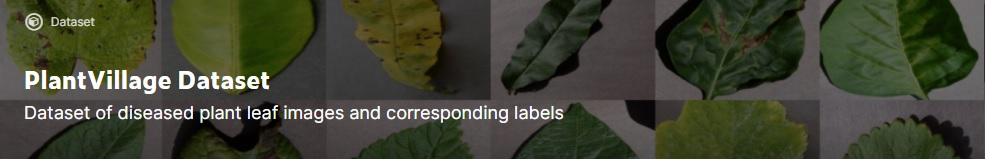

This Notebook is a Data Vizualiation exploration notebook. 

The aim is to explore the dataset more in detail and provide some key information using Visualiation tools.

In [ ]:
#install Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Unzip Plant_Village.zip from Drive to Colab
!unzip -u "/content/drive/MyDrive/20 - Data/Plant_Village.zip" -d "/content/sample_data"

#Unzip Plant_Village.zip from Drive to Colab
!unzip -u "/content/drive/MyDrive/20 - Data/image-net_valid_64x64.zip" -d "/content/sample_data"

In [ ]:
# Import required packages
import os
import pandas as pd
import seaborn as sns
import numpy as np
from PIL import Image
import io
from google.colab import files
import matplotlib.pyplot as plt
%matplotlib inline

# Import Bokeh for visualization
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import HoverTool, ColumnDataSource, FactorRange
from bokeh.transform import factor_cmap
from bokeh.palettes import plasma

# Import for Data augmentation
from torchvision import transforms
import random

# Précision de l'affichage des graphiques dans des cellules jupyter
output_notebook()

In [ ]:
# Get Path to DataSet Plant Village folders
data_path = '/content/sample_data/plantvillage dataset/segmented'

# Get Path to DataSet Image-Net folders
data_path_other = '/content/sample_data/image-net_valid_64x64'

# Get list of all subfolders for each Subset
data_dir = os.listdir(data_path)


# Plant Village Dataset - Data Visualisation

##Introduction

**General DataSet description**

The purpose of this project is, from a photo of a plant leaf, to determine which plant it is, whether the plant is healthy or which disease the plant is affected.  
This notebook presents the Dataset **Plant Village Dataset** from **Kaggle**: https://www.kaggle.com/abdallahalidev/plantvillage-dataset

The names and categories of each plants are based on the directory structure.

Folders structure is as below:
- For diseased plants: `[Name of the plants]___[name of the disease]`
- For healthy plants: `[Name of the plants]___healthy`

This Dataset contains 3 types of images: colored images, grayscale images and segmented images. As we want to add a background to the images, only the segmented images will be used

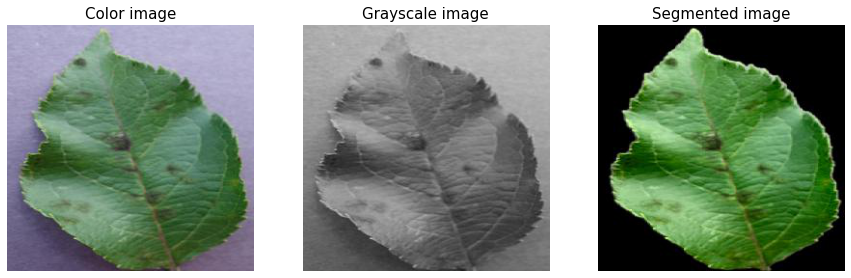

In [ ]:
#@title
#Plot on leaf fro color, grayscale, sgmented folder
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.title('Color image', fontsize=15)
image=Image.open('/content/sample_data/plantvillage dataset/color/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG')
plt.imshow(image)
plt.axis('off')
plt.subplot(1,3,2)
plt.title('Grayscale image', fontsize=15)
image2=Image.open('/content/sample_data/plantvillage dataset/grayscale/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG')
plt.imshow(image2)
plt.axis('off')
plt.subplot(1,3,3)
plt.title('Segmented image', fontsize=15)
image3=Image.open('/content/sample_data/plantvillage dataset/segmented/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335_final_masked.jpg')
plt.imshow(image3)
plt.axis('off');

**Creation of DataFrame which summarize images data & Creation of DataFrame which summarize the number of images per class**

In [ ]:
#@title

#Creation of data frames which explain for each image :Plant','Category','Disease','Path','Plant___Category'

def Create_DF_DataSet_Info(path):

  List_Plant=[]
  List_Category=[]
  List_Disease=[]
  List_Path=[]
  List_Plant___Category=[]
  List_Image_size=[]
  List_Image_type=[]
  List_size=[]

  for path, dirs, files in os.walk(path,topdown=False):
    for name in files:
      plant___category=category=path.split('/')[-1]
      plant=plant___category.split('___')[0]
      category=plant___category.split('___')[-1]
      disease= 0 if category=='healthy' else 1
      full_path=path+'/'+name
      Image_type=name.split('.')[-1]
      size=os.path.getsize(full_path)

      with Image.open(full_path) as img:
        width, height = img.size
        List_Plant.append(plant)
        List_Category.append(category)
        List_Disease.append(disease)
        List_Path.append(full_path)
        List_Plant___Category.append(plant___category)
        List_Image_size.append(str(width)+'x'+str(height))
        List_Image_type.append(Image_type)
        List_size.append(size)

  df_info=pd.DataFrame.from_dict({'Plant':List_Plant,'Category':List_Category,'Disease':List_Disease,'Path':List_Path,
                                  'Plant___Category':List_Plant___Category,'Image_size':List_Image_size,
                                  'Image_type':List_Image_type,"Size":List_size}, orient = 'columns')
  df_image_count=pd.DataFrame(df_info.groupby(['Plant','Category','Plant___Category']).size())
  df_image_count.rename(columns={0: 'nb'}, inplace=True)
  df_image_count=df_image_count.reset_index()

  return df_info,df_image_count

dataset_info,dataset_count=Create_DF_DataSet_Info(data_path)

In [ ]:
dataset_info.head()

,Plant,Category,Disease,Path,Plant___Category,Image_size,Image_type,Size
0,Potato,Late_blight,1,/content/sample_data/plantvillage dataset/segm...,Potato___Late_blight,256x256,jpg,9827
1,Potato,Late_blight,1,/content/sample_data/plantvillage dataset/segm...,Potato___Late_blight,256x256,jpg,10324
2,Potato,Late_blight,1,/content/sample_data/plantvillage dataset/segm...,Potato___Late_blight,256x256,jpg,10179
3,Potato,Late_blight,1,/content/sample_data/plantvillage dataset/segm...,Potato___Late_blight,256x256,jpg,11324
4,Potato,Late_blight,1,/content/sample_data/plantvillage dataset/segm...,Potato___Late_blight,256x256,jpg,8957


In [ ]:
dataset_count.head()

,Plant,Category,Plant___Category,nb
0,Apple,Apple_scab,Apple___Apple_scab,630
1,Apple,Black_rot,Apple___Black_rot,621
2,Apple,Cedar_apple_rust,Apple___Cedar_apple_rust,275
3,Apple,healthy,Apple___healthy,1645
4,Blueberry,healthy,Blueberry___healthy,1502


## Visualisation of sample leaves



Visualisation of one leaf for each plant and for each plant category.

We can notice that:
- There is one leaf per image.
- Leaves seems to be centered in the image.
- Leaves' photos are not taken on the trees.
- Background is black.


In [ ]:
#Plot 1 image for each plant categorie and for each plant diseases
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

list_plant=list(dataset_count.Plant.unique())
for plant in list_plant:  
  list_disease=dataset_info.Category[dataset_info['Plant']==plant].unique().tolist()
  
  if len(list_disease)<5:
    rows=1
    cols = len(list_disease)
  else:
    cols = 4
    rows = len(list_disease)//4+1
  fig, ax = plt.subplots(nrows=rows, ncols=cols,figsize=(cols*5,rows*5 ),squeeze=False)

  fig.suptitle(plant, fontsize=20)
  row=0
  col=0

  for diseases in list_disease:
    if col <4:
      col+=1
      row=row
    else:
      col=1
      row+=1 
    
    img = plt.imread(dataset_info[(dataset_info.Plant==plant) & (dataset_info.Category==diseases)].iloc[2,3])
    ax[row, col-1].axis('off')
    ax[row, col-1].set_title(diseases)
    ax[row, col-1].imshow(img)


Output hidden; open in https://colab.research.google.com to view.

## DataSet information

In [ ]:
#@title
print('\033[1m Summary \033[0m')
print('Images type :',dataset_info.Image_type.unique().tolist())
print('Images dimensions :',dataset_info.Image_size.unique().tolist())
print('Images number :',len(dataset_info))
print('Images size: min=:{:.2f} kb, max=:{:.2f} kb, mean=:{:.2f} kb, Total=:{:.0f} kb'.format(dataset_info.Size.min()/1000,dataset_info.Size.max()/1000,dataset_info.Size.mean()/1000,dataset_info.Size.sum()/1000))


**Summary :**
* Images type : JPEG
* Images dimensions : 256x256, 335x512, 466x512, 324x512, 470x512
* Images color: RGB
* Images number : 54 306
* Images size : min= 1.10 kb, max= 110.14 kb, mean= 9.46 kb, Total= 513.46 Mb


## Class distribution

**Number of images per Plants**

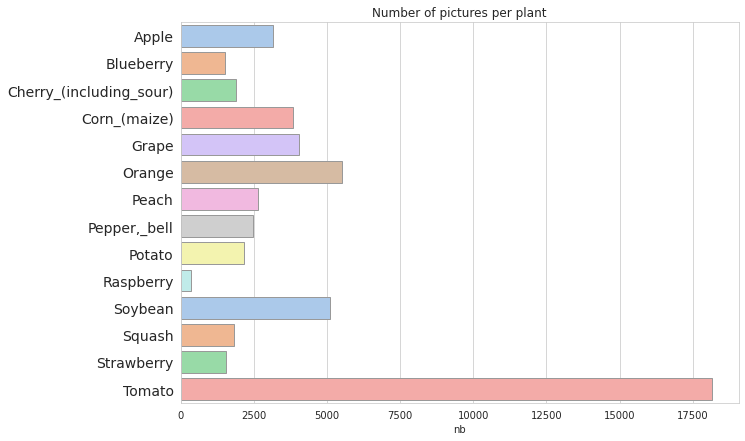

In [ ]:
#@title
#Plot number of image per plant
def plot_image_nb_per_plant(dataset_count):
  kind=list(dataset_count['Plant'].unique())
  count=dataset_count.groupby(by=['Plant'])['nb'].sum()
  sns.set_style("whitegrid")
  bar,ax = plt.subplots(figsize=(10,7))
  ax.set_yticklabels(kind, fontsize=14)
  ax=sns.barplot(x=count,y=kind,palette="pastel", edgecolor=".6",data=dataset_count).set_title("Number of pictures per plant")

plot_image_nb_per_plant(dataset_count)


**Healthy VS disease plant images distribution**

Number of healthy plants: 15084
Number of diseased plants: 39222

Number of Healthy Categories: 12
Number of Diseased Categories: 26


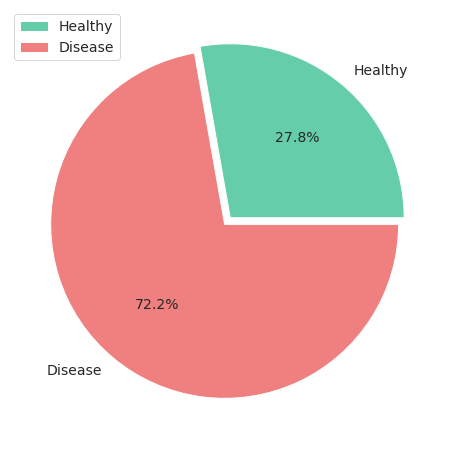

In [ ]:
#@title

def plot_image_healthy_vs_disease(dataset_count):
  plt.figure(figsize = (15, 8))
  plt.rcParams['font.size'] = 14
  plt.pie([dataset_count.nb[dataset_count.Category=='healthy'].sum(), dataset_count.nb[dataset_count.Category!='healthy'].sum()],labels=["Healthy", "Disease"],autopct = lambda x: str(round(x, 1)) + '%',colors = ["mediumaquamarine","lightcoral"],shadow=False,explode=(0.05,0))
  plt.legend();

  print(f"Number of healthy plants: {dataset_count.nb[dataset_count.Category=='healthy'].sum()}")
  print(f"Number of diseased plants: {dataset_count.nb[dataset_count.Category!='healthy'].sum()}")
  print(f"\nNumber of Healthy Categories: {dataset_count.nb[dataset_count.Category =='healthy'].count()}")
  print(f"Number of Diseased Categories: {dataset_count.nb[dataset_count.Category !='healthy'].count()}")

plot_image_healthy_vs_disease(dataset_count)

**Class distribution**

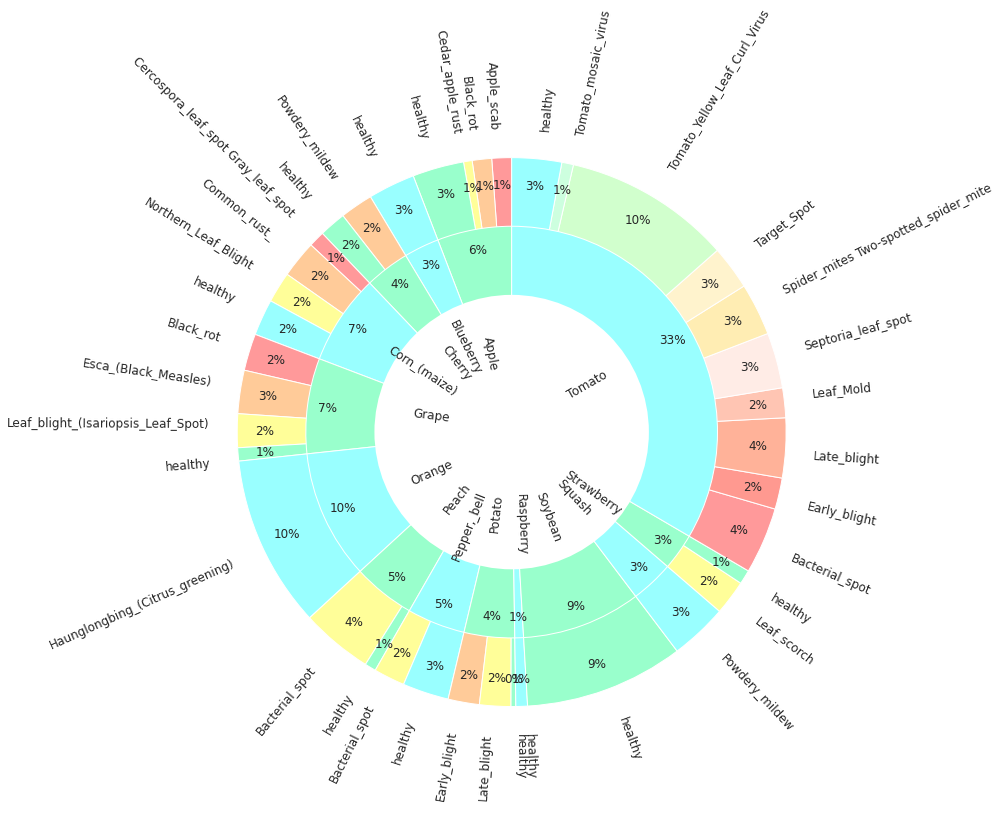

In [ ]:
#@title
def plot_classes_distribution(dataset_count,dataset_info):
  liste_plant_modif = ['Cherry' if x == 'Cherry_(including_sour)' else x for x in list(dataset_count.Plant.unique())]

  # Data to plot
  colors1 = ['#99ffcc', '#99ffff', '#99ffcc', '#99ffff','#99ffcc', '#99ffff','#99ffcc', '#99ffff','#99ffcc', '#99ffff','#99ffcc', '#99ffff','#99ffcc', '#99ffff',]
  colors2 = ['#ff999a','#ffcb99', '#fffe99','#99ffcc',
             '#99ffff',
             '#ffcb99', '#99ffcc',
             '#ff999a','#ffcb99','#fffe99','#99ffff',
             '#ff999a','#ffcb99','#fffe99','#99ffcc',
             '#99ffff',
             '#fffe99','#99ffcc',
             '#fffe99','#99ffff',
             '#ffcb99','#fffe99','#99ffcc',
             '#99ffff',
             '#99ffcc',
             '#99ffff',
             '#fffe99','#99ffcc',
             '#ff999a','#ff9990','#ffb299','#ffc5b3','#ffece6','#ffedb3','#fff3cd','#d1ffcd','#cdffdf','#99ffff']
 
  # Plot Pie Plot
  plt.figure(figsize = (14, 14))

  plt.pie(dataset_count.nb, labels=dataset_count.Category,  startangle=90,frame=True,radius=1,rotatelabels=True,colors=colors2,wedgeprops=dict(width=0.9, edgecolor='w'),autopct='%1.f%%',pctdistance=0.90, textprops={'fontsize': 12})
  plt.pie(dataset_info.groupby(['Plant']).size(),labels=liste_plant_modif,radius=0.75,startangle=90,labeldistance=0.3,rotatelabels=True,colors=colors1,wedgeprops=dict(width=0.9, edgecolor='w'),autopct='%1.f%%',pctdistance=0.90, textprops={'fontsize': 12})
  centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)
  fig = plt.gcf()
  fig.gca().add_artist(centre_circle)
 
  plt.axis('equal')
  plt.tight_layout()
  plt.show()

plot_classes_distribution(dataset_count,dataset_info)


**Number of images per plant diseases**

In [ ]:
#@title
# Visualisation of Number of images per folders
def image_number_per_classe(dataset_count):
  # Get Tuple list of (Plants, Status)
  x = list(dataset_count[['Plant', 'Category']].itertuples(index=False, name=None))
  x= [('Cherry', a[1]) if a[0] == 'Cherry_(including_sour)' else (a[0], a[1]) for a in x]
  # Get same color
  colors =plasma(14)

  index_cmap = factor_cmap('x', palette=colors, factors=sorted(dataset_count['Plant'].replace({'Cherry_(including_sour)':'Cherry'}).unique()), end=1)

  # Source instanciation
  source = ColumnDataSource({
         'x': x,
         'top': dataset_count['nb'],
  })
  # Create factor
  factor = FactorRange(factors = x)

  # Hover tool
  tool_tuple = [('Plant: ', '@x'), ('# Images: ', '@top')]

  # Create Figure - Bar chart
  p = figure(plot_width=1400, plot_height=600, x_range=factor)
  bar = p.vbar(width=0.9, x='x', top='top', source=source,
               fill_color=index_cmap, line_color="white")
  # Orientation of the axis labels
  p.xaxis.major_label_orientation = np.pi/2

  # Create Hover tool and add it to the graph
  hover = HoverTool(renderers = [bar], tooltips = tool_tuple)
  p.add_tools(hover)

  # Show Graph
  show(p)

image_number_per_classe(dataset_count)



## Summary of original DataSet

To sum up what we have seen above:
* Images type : JPEG
* Images dimensions : 256x256, 335x512, 466x512, 324x512, 470x512
* Image color: RGB

We have **14** types of plants, under **38** categories:
* **26** categories of diseased plants
* **12** categories of healthy plants

**This DataSet is highly unbalanced and need data augmentation for most of classes**

We are dealing with images (unstructured data), so it's probably best we use Deeplearning models.



#Plant Village Dataset - Data Augmentation

Images augmentation is done using Pytorch torchvision.transforms. These transformations are applied randomly several times on each images of classe folders until the number of images is above 2000 images. If the number of images from original DataSet classe is above 2000 images only a resize transformation is apply.

Below the transformation applied on images:


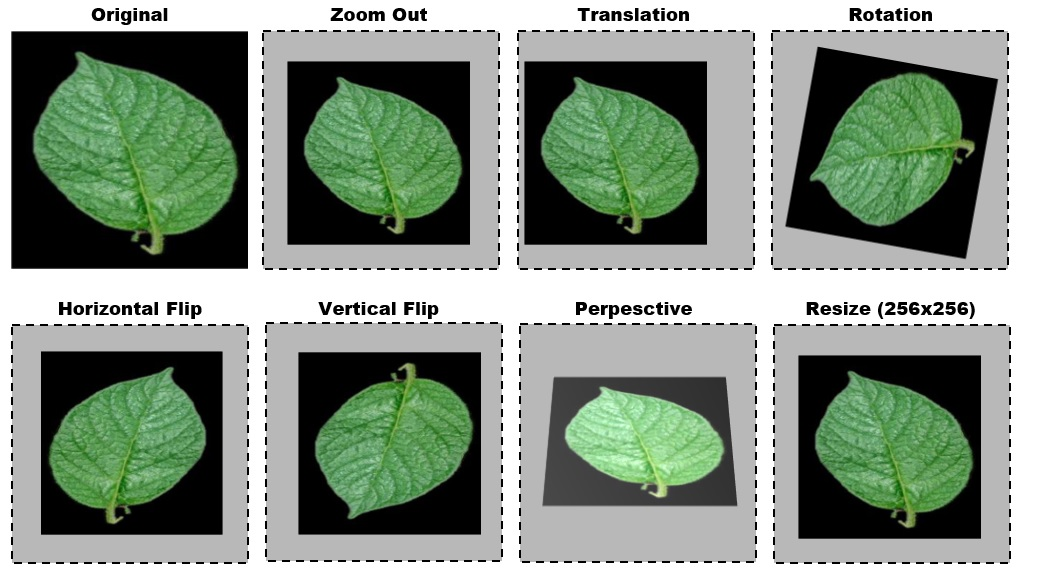

In [ ]:
# Parameters
#-------------------------------------------------------------------------------
nb_image_min=2000 # Min images number par class
TARGET_SIZE = (256, 256) # Target size after resized image
tr_pad_liste=[(0,0),(16,16),(32,32),(40,40),(48,48),(56,56),(64,64)] # List of Pad
tr_angle=60 # Rotaion max
data_path_augmented = '/content/sample_data/plantvillage_dataset_augmented' # Get Path to DataSet folders

In [ ]:
#Create image folder for data augmentation
#-------------------------------------------------------------------------------
os.makedirs(data_path_augmented)
rep=[]
for path, dirs, files in os.walk(data_path,topdown=False):
    rep.append(dirs)
for i in rep[-1]:
    os.makedirs(os.path.join(data_path_augmented,i))

#Calculate the number of times that transformations have to be applied on each images
#-------------------------------------------------------------------------------
list_path=dataset_info.Path.to_list()
list_label=dataset_info.Plant___Category.to_list()
liste_ratio=[]
list_classes = sorted(list(set(list_label)))


for cl in list_classes:
    nb=list_label.count(cl)
    ratio_augment=int(nb_image_min/nb)+1
    liste_ratio.append(ratio_augment)

#Applied transformations on each image and save it
#-------------------------------------------------------------------------------
transform_composed=transforms.Compose([transforms.Pad(random.choice(tr_pad_liste),fill=0),
                                       transforms.RandomAffine(0, translate=(0.1,0.1) ),
                                       transforms.RandomRotation(tr_angle),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomVerticalFlip(p=0.5),
                                      transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=2),
                                      transforms.Resize(TARGET_SIZE)])


for i,image_path in enumerate(list_path):
    classes=list_label[i]
    nb_transform=liste_ratio[list_classes.index(classes)]
    image = Image.open(image_path)
    width, height = image.size
    if width!=256 or height!=256:
      image=transforms.Resize(TARGET_SIZE)(image)
    image.save(os.path.join(data_path_augmented,classes,'im'+str(i)+".jpg"))
    
    for k in range(nb_transform-1):
        tr_pad=random.choice(tr_pad_liste)
        image_transformed=transform_composed(image)
        image_transformed.save(os.path.join(data_path_augmented,classes,'im'+str(i)+'tr'+str(k)+".jpg"))


# Adding a class "Other" from image-net

In order to improve our model, another class ('Others') is added to our DataSet using 2000 images extracted from the validation (64x64) dataset from http://www.image-net.org/

In [ ]:
#Create a list which contain all images paths od image-net dataset
liste_path_image_net=[]
for path, dirs, files in os.walk(data_path_other,topdown=False):
  for name in files:
    liste_path_image_net.append(os.path.join(path,name))

Below, a sample of images from Image-Net:

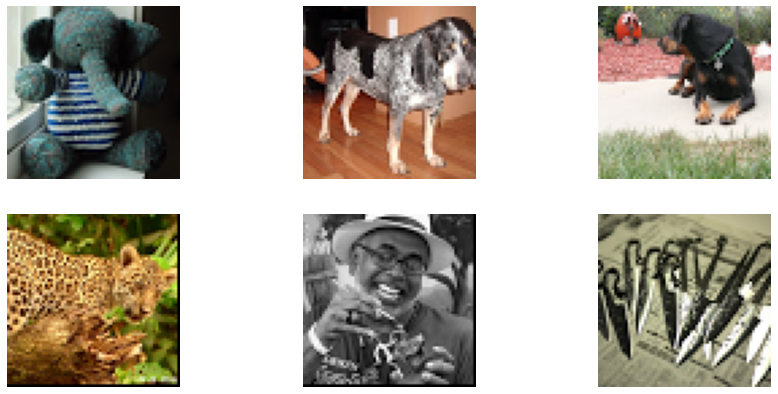

In [ ]:
#@title
#Plot 6 images from image-net
plt.figure(figsize=(15,7))

for i in range(1,7,1):
  plt.subplot(2,3,i)
  image=Image.open(random.choice(liste_path_image_net))
  plt.imshow(image)
  plt.axis('off')

Image-Net images size is 64x64, as images size of our DataSet (with images augmentation) is 256x256, Image-Net images are resized to 256x256.
See below the result of this resizing:

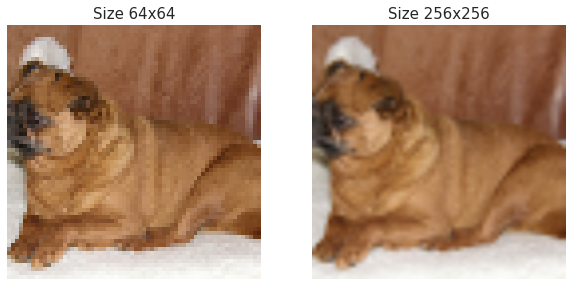

In [ ]:
#@title
#Plot Image-Net images size 64x64 and 256x265
plt.figure(figsize=(10,7))
image1=Image.open(random.choice(liste_path_image_net))
image1 = image1.convert('RGB')
image2=transforms.Resize(TARGET_SIZE)(image1)
plt.subplot(1,2,1)
plt.title('Size 64x64', fontsize=15)
plt.imshow(image1)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Size 256x256', fontsize=15)
plt.imshow(image2)
plt.axis('off');

In [ ]:
#Choose randomly 2000 images from Image-Net dataset, resize them in 256x256 and save them in the new DatSet
os.makedirs(os.path.join(data_path_augmented,'Others___Others'))

image_net_sample=random.sample(liste_path_image_net,2000)
for i in range(2000):
  image1=Image.open(image_net_sample[i])
  image = image.convert('RGB')
  image=transforms.Resize(TARGET_SIZE)(image)
  image.save(os.path.join(data_path_augmented,'Others___Others','image-net'+str(i)+".jpg"))

In [ ]:
# Zip augmented images Dataset
!zip -r /content/sample_data/Plant_Village_augmented.zip /content/sample_data/plantvillage_dataset_augmented

# Plant Village Augmented Dataset - Data Visualisation

Below is the new summary of our dataset after:
- The data augmentation on categories with low number of original leaves images
- The new "Other" category

The aim is to balance as much as possible this dataset and provide an harmonisation between all images (size, number, color...)

## DataSet information

In [ ]:
#@title
dataset_augment_info,dataset_augment_count=Create_DF_DataSet_Info(data_path_augmented)
print('\033[1m Summary \033[0m')
print('Images type :',dataset_augment_info.Image_type.unique().tolist())
print('Images dimensions :',dataset_augment_info.Image_size.unique().tolist())
print('Images number :',len(dataset_augment_info))
print('Images size: min=:{:.2f} kb, max=:{:.2f} kb, mean=:{:.2f} kb, Total=:{:.0f} kb'.format(dataset_augment_info.Size.min()/1000,dataset_augment_info.Size.max()/1000,dataset_augment_info.Size.mean()/1000,dataset_augment_info.Size.sum()/1000))


 Summary 
Images type : ['jpg']
Images dimensions : ['256x256']
Images number : 111077
Images size: min=:1.10 kb, max=:29.43 kb, mean=:8.80 kb, Total=:977259 kb


**Summary :**
* Images type : JPEG
* Images dimensions : 256x256
* Images color: RGB
* Images number : 111 077
* Images size : min= 1.10 kb, max= 29.43 kb, mean= 8.80 kb, Total= 977.259 Mb

## Class distribution

**Number of images per Plants**

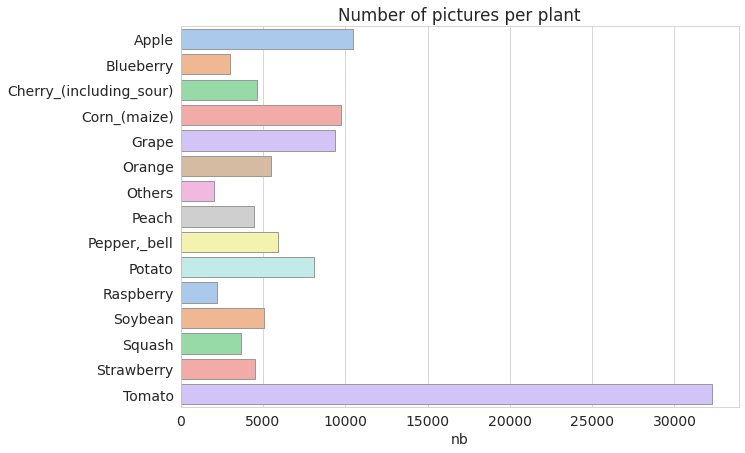

In [ ]:
plot_image_nb_per_plant(dataset_augment_count)

**Healthy VS disease plant images distribution**

Number of healthy plants: 33317
Number of diseased plants: 77760

Number of Healthy Categories: 12
Number of Diseased Categories: 27


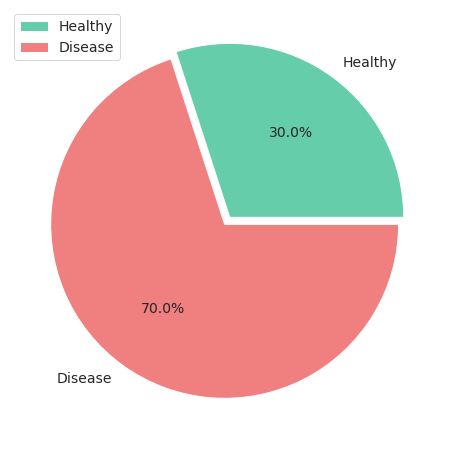

In [ ]:
#@title
plot_image_healthy_vs_disease(dataset_augment_count)

**Class distribution**

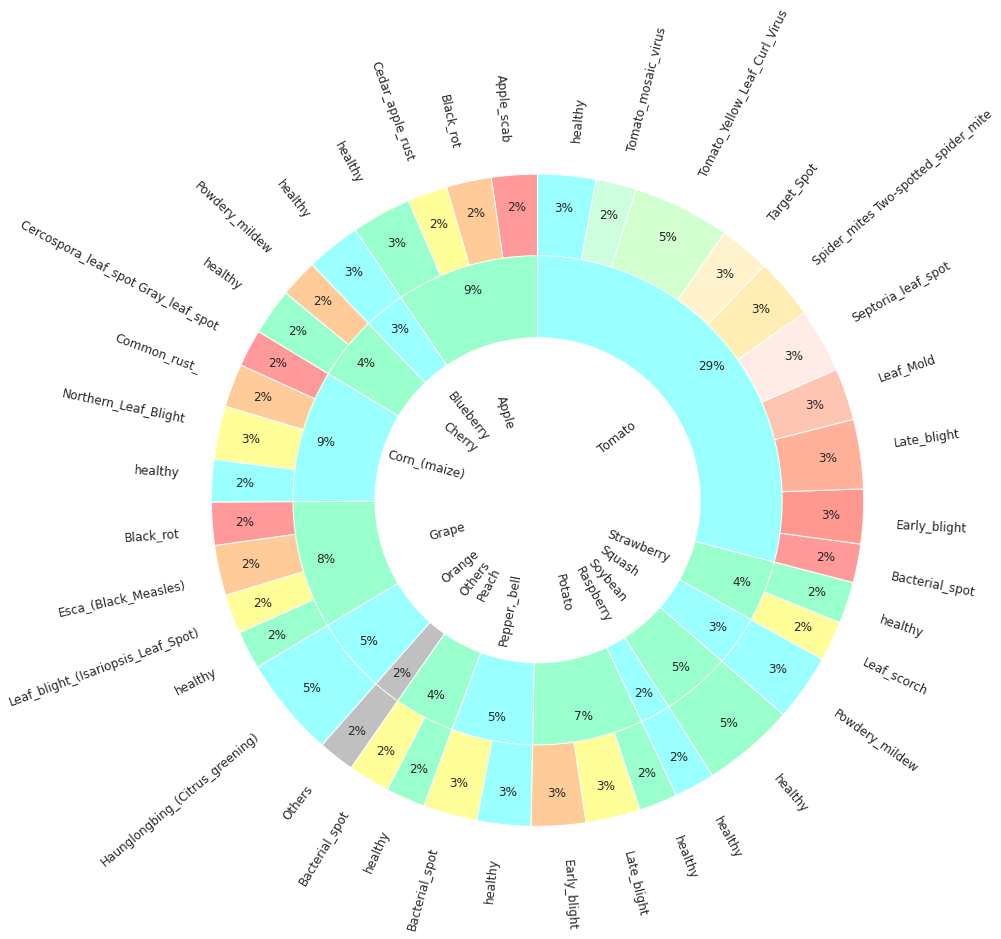

In [ ]:
#@title
def plot_classes_distribution2(dataset_count,dataset_info):
  liste_plant_modif = ['Cherry' if x == 'Cherry_(including_sour)' else x for x in list(dataset_count.Plant.unique())]

  # Data to plot
  colors1 = ['#99ffcc', '#99ffff', '#99ffcc', '#99ffff','#99ffcc', '#99ffff','silver','#99ffcc', '#99ffff','#99ffcc', '#99ffff','#99ffcc', '#99ffff','#99ffcc', '#99ffff']
  colors2 = ['#ff999a','#ffcb99', '#fffe99','#99ffcc',
             '#99ffff',
             '#ffcb99', '#99ffcc',
             '#ff999a','#ffcb99','#fffe99','#99ffff',
             '#ff999a','#ffcb99','#fffe99','#99ffcc',
             '#99ffff',
             'silver',
             '#fffe99','#99ffcc',
             '#fffe99','#99ffff',
             '#ffcb99','#fffe99','#99ffcc',
             '#99ffff',
             '#99ffcc',
             '#99ffff',
             '#fffe99','#99ffcc',
             '#ff999a','#ff9990','#ffb299','#ffc5b3','#ffece6','#ffedb3','#fff3cd','#d1ffcd','#cdffdf','#99ffff']
 
  # Plot Pie Plot
  plt.figure(figsize = (14, 14))

  plt.pie(dataset_count.nb, labels=dataset_count.Category,  startangle=90,frame=True,radius=1,rotatelabels=True,colors=colors2,wedgeprops=dict(width=0.9, edgecolor='w'),autopct='%1.f%%',pctdistance=0.90, textprops={'fontsize': 12})
  plt.pie(dataset_info.groupby(['Plant']).size(),labels=liste_plant_modif,radius=0.75,startangle=90,labeldistance=0.3,rotatelabels=True,colors=colors1,wedgeprops=dict(width=0.9, edgecolor='w'),autopct='%1.f%%',pctdistance=0.90, textprops={'fontsize': 12})
  centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)
  fig = plt.gcf()
  fig.gca().add_artist(centre_circle)
 
  plt.axis('equal')
  plt.tight_layout()
  plt.show()

plot_classes_distribution2(dataset_augment_count,dataset_augment_info)

**Number of images per plant diseases**

In [ ]:
#@title
image_number_per_classe(dataset_augment_count)

/usr/local/lib/python3.6/dist-packages/bokeh/models/mappers.py:147: UserWarning: Palette length does not match number of factors. ['Tomato'] will be assigned to `nan_color` gray
  warnings.warn("Palette length does not match number of factors. %s will be assigned to `nan_color` %s" % (extra_factors, self.nan_color))


# Summary of Augmented DataSet

To sum up what we have seen above:
* Images type : JPEG
* Images dimensions : 256x256
* Image color: RGB

We have **14** types of plants, under **38** categories and one more category for others types:
* **26** categories of diseased plants
* **12** categories of healthy plants
* **1**  category for others types

**All classes have more than 2000 images**

We are dealing with images (unstructured data), so it's probably better to  use Deeplearning models.
